In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Загрузка данных

In [2]:
df = pd.read_csv('stratification_task_data_public.csv')
df.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.869,30,33.8,0,1,0.2,1992,1,1,1,1903
1,0.759,27,21.7,2,0,3.5,1995,1,1,2,1313
2,0.456,29,37.6,2,0,3.1,1993,0,0,0,1484
3,0.060,35,27.5,2,0,4.7,1988,0,0,1,1188
4,0.939,19,30.7,0,0,3.6,2003,1,1,2,842
5,0.261,25,22.6,2,1,5.0,1998,1,0,1,972
6,0.427,32,24.8,0,0,3.8,1991,0,1,1,748
7,0.260,34,23.6,2,0,2.2,1989,0,0,1,1312
8,0.554,25,27.5,2,0,0.9,1997,1,1,0,1263
9,0.114,31,25.4,0,0,0.5,1991,0,1,2,1779


## 2. Вычисление дисперсии

Посчитаем дисперсию без разбиения на страты, чтобы знать с чем сравниваться в дальнейшем.

In [3]:
def calculate_strat_var(df):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('strat')['y'].var()
    weights = df['strat'].value_counts(normalize=True)
    stratified_var = (strat_vars * weights).sum()
    return stratified_var

In [4]:
df['strat'] = 0
calculate_strat_var(df)

66078.09433343346

## 3. Снижаем дисперсию

### 3.1. Категориальные признаки

Чтобы дисперсия снизилась, нужно разбить на страты так, чтобы средние значения в стратах отличались.

Посчитаем количество уникальных значений в столбцах

In [5]:
df.nunique()

x1       1001
x2         36
x3        414
x4          3
x5          2
x6        238
x7         35
x8          2
x9          2
x10         9
y        1313
strat       1
dtype: int64

Сначала рассмотрим признаки, у которых сравнительно мало уникальных значений. Такие признаки называют категориальными. Часто с их помощью кодируют значения мужчина/женщина, android/ios, онлайн/оффлайн и так далее.

- Вычислим для каждого значения признака среднее значение метрики;
- Попробуем использовать каждый признак как способ разбиения на страты, вычислим дисперсии.

In [6]:
features_one = ['x4', 'x5', 'x8', 'x9']

for feature in features_one:
    print(f'feature = {feature}')
    print(df.groupby(feature)['y'].mean().astype(int))
    df['strat'] = df[feature]
    print(f'var = {calculate_strat_var(df):0.0f}')
    print()
    

feature = x4
x4
0    1360
1    1375
2    1367
Name: y, dtype: int64
var = 66054

feature = x5
x5
0    1361
1    1377
Name: y, dtype: int64
var = 66022

feature = x8
x8
0    1320
1    1393
Name: y, dtype: int64
var = 64859

feature = x9
x9
0    1375
1    1363
Name: y, dtype: int64
var = 66051



Отличия среднего значения метрики между стратами получились небольшими. Дисперсия уменьшилась в лучшем случае до `64859` для признака `x8`.

Можно рассмотреть комбинации признаков. Например, составить стату из комбинаций признаков `x8` и `x9`:

- страта 1: `x8=0, x9=0`
- страта 2: `x8=0, x9=1`
- страта 3: `x8=1, x9=0`
- страта 4: `x8=1, x9=1`

Такой подход может дать значитальное снижение дисперсии. При желании, можете это реализовать.

### 3.2. Непрерывные признаки

Непрерывные признаки - это данные, которые могут принимать любые значения в некотором интервале.

Разобъём признаки на группы по квантилям, это обеспечит более-менее равномерное распределение объектов по стратам отличие среднего значения признака между стратами. Вычислим средние значения метрики для групп, построим графики и вычислим дисперсии.

feature = x1
var = 66064


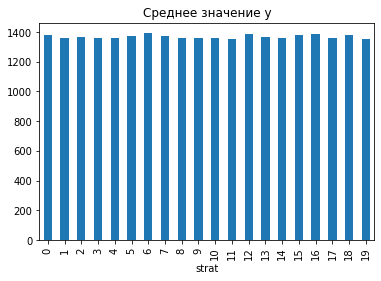


feature = x3
var = 65321


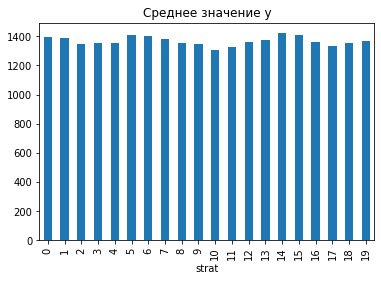


feature = x6
var = 66003


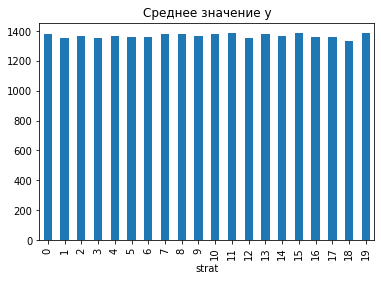

In [7]:
features_two = ['x1', 'x3', 'x6']
quantile_number = 20

for feature in features_two:
    print(f'feature = {feature}')
    quantiles = np.linspace(1/quantile_number, 1, quantile_number)
    quantile_values = np.quantile(df[feature].values, quantiles)
    df['strat'] = [np.sum(x > quantile_values) for x in df[feature].values]
    print(f'var = {calculate_strat_var(df):0.0f}')
    df.groupby('strat')['y'].mean().plot(kind='bar')
    plt.title('Среднее значение y')
    plt.show()
    print()
    

Сильных зависимостей целевой переменной от значений непрерывных признаков не видно. Лучшее снижение дисперсии получено при разбиении по признаку `x3`, дисперсия равна `65321`.

### 3.3. Остальные признаки

Рассмотрим оставшиеся признаки, которые и не непрерывные, и к категориальным относятся с натяжкой из-за сравнительно большого количества категорий. Если использовать эти признаки в качестве страт, то доля некоторых страт будет меньше 5%, что не подходит по условию.

Признаки `x2` и `x7` похожи на возраст и год рождения, они очень скоррелированы. Будем рассматривать только один из них, так как второй несёт мало дополнительной информации.

In [8]:
df[['x2', 'x7']].head()

,x2,x7
0,30,1992
1,27,1995
2,29,1993
3,35,1988
4,19,2003


In [9]:
# корреляция
df[['x2', 'x7']].corr()

,x2,x7
x2,1.000000,-0.994133
x7,-0.994133,1.000000


Вычислим средние значения целевой переменной и количество объектов для каждого значения признака, построим графики и вычислим дисперсии.

feature = x2
var = 47232


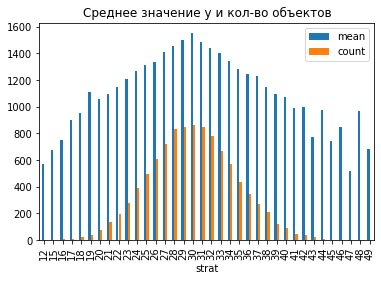


feature = x10
var = 63756


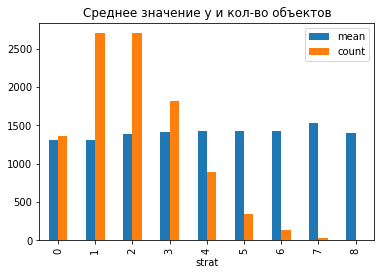

In [10]:
features_three = ['x2', 'x10']

for feature in features_three:
    print(f'feature = {feature}')
    df['strat'] = df[feature]
    print(f'var = {calculate_strat_var(df):0.0f}')
    df.groupby('strat')['y'].agg(['mean', 'count']).plot(kind='bar')
    plt.title('Среднее значение y и кол-во объектов')
    plt.show()
    print()
    

Распределение на страты по признаку `x2` снизило дисперсию до `47232`. Но при таком разбиении у нас некоторые страты составляют менее 5% данных. Объединим некоторые старты вместе, так чтобы доли страт были не менее 5%.

- 23 и меньше
- 24 и 25
- с 26 до 33 - каждое значение отдельная страта
- 34 и 35
- 36 и более

In [11]:
def get_strat_one(x):
    if x < 24:
        return 23
    elif x < 26:
        return 25
    elif x < 34:
        return x
    elif x < 36:
        return 35
    else:
        return 36

df['strat'] = [get_strat_one(x) for x in df['x2']]
print(f'var = {calculate_strat_var(df):0.0f}')
min_part = df['strat'].value_counts(normalize=True).min()
print(f"min_part = {min_part:0.3f}")

var = 49120
min_part = 0.060


Поличили дисперсию `49120` и минимальную долю страты `6%`.

Распределение среднего значения метрики в зависимости от `x2` похоже на симметричное с осью симметрии около `x2=30`. Средние значения метрики для симметричных значений `x2` похожи. Можно разбить на страты с учётом симметрии.

In [12]:
def get_strat_two(x):
    if (x < 25) or (x > 35):
        return 1
    elif (x < 27) or (x > 33):
        return 2
    elif (x < 29) or (x > 31):
        return 3
    else:
        return 4

df['strat'] = [get_strat_two(x) for x in df['x2']]
print(f'var = {calculate_strat_var(df):0.0f}')
min_part = df['strat'].value_counts(normalize=True).min()
print(f"min_part = {min_part:0.3f}")

var = 49851
min_part = 0.211


Получили прирно такую же дисперсию, а минимальный размер увеличился. Это даёт возможность произвести дополнительное разбиение по другим признакам.

### 3.4. Страты из нескольких признаков.

Попробуем объединить разбиение на страты по признаку `x2` с разбиением по другим признакам.

В разделе 3.1. минимальная дисперсия была при разбиении по признаку `x8`, попробуем использовать его. 

In [13]:
df['strat'] = [str(get_strat_two(a)) + str(b) for a, b in df[['x2', 'x8']].values]
print(f'var = {calculate_strat_var(df):0.0f}')
min_part = df['strat'].value_counts(normalize=True).min()
print(f"min_part = {min_part:0.3f}")


var = 48502
min_part = 0.076


Новый рекорд! Дисперсия равна `48502`.